Import libraries and define main constants

TODO : 
* Question 4...
    * Calculer tous les pearsons coefficients pour essayer de trouver des corrélations.
    * A voir si tu trouves/penses à d'autres méthodes
* Verifier résultats question 1 + 2 (j'ai c/c pour la question 2 par exemple) puis les commenter
* Ajouter les plots par région pour la question 2 -> comment associer pays et région ? 
* Question 5 : analyser chaque classement, faire des comparatifs entre eux, éventuellement tenter méthode électre


**Globalement** :  bien commenter toutes les méthodes. Justifier d'avantages nos choix. Analyser les résultats

In [122]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import seaborn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

TOP_UNIVERSITIES_BASE_URL = "https://www.topuniversities.com"
TIMES_BASE_URL = "https://www.timeshighereducation.com/"
# Max rank to load for each ranking
MAX_RANK=200 # 200

## Cached requests

The following method adds a cache for simple HTTP GET requests and ensures that at most one request will be sent per unique URL.

**Re-evalute the cell with the function to flush the cache.**

In [2]:
CACHE = {}
def cached_get_request(url, cache=CACHE):
    """
    Perform a cached HTTP GET request for `url`.
    
    The first time you send a request for an `url`, it will effectivelly
    send an HTTP request. The response will be cached in `cache` and each
    subsequent call for a cached URL will use a cache lookup using an exact
    match on the url instead of sending a new HTTP request.
    
    This function will use a shared cache by default, you can provide your
    own dictionary if you want to override this behavior.
    Reevalute this function to flush the shared cache.
    
    :param url str: URL to GET
    :cache: A dictionary from urls to HTTP responses. Mutated if it did not contain the key `url`.
    :return: _requests_' response for the provided URL.
    """
    
    if url not in cache:
        cache[url] = requests.get(url)
    return cache[url]

We define a few functions used to read the data
- `read_rank` allows to convert a string of the form `"=40"` to `40`, `"10-12"` to `10` (TODO: give example with em dash)
- `read_us_formatted_integer` allows to convert string representation with a comma used used as the thousands separtor.

In [3]:
def read_rank(raw_rank):
    """
    :param raw_rank str: Rank string, as found by scrapping
    :return int: Integer representing the rank of the university
    """
    if '-' in raw_rank:
        return int(raw_rank[:raw_rank.index('-')])
    if '–' in raw_rank:
        return int(raw_rank[:raw_rank.index('–')])
    return int(raw_rank.replace('=', ''))

In [4]:
def read_us_formatted_integer(raw_integer):
    """
    Reads a string representing an integer properly formatted using US convention.
    
    The US format uses commas as the thousands separator.
    
    Examples:
    ```
    >>> read_us_formatted_integer("0")
    0
    >>> read_us_formatted_integer("1,000")
    1000
    >>> read_us_formatted_integer("999,999,999")
    999999999
    
    ```
    :param raw_integer str: US Formatted string for an integer
    :return int: Integer corresponding to the provided value.
    """
    return int(raw_integer.replace(",", ""))

In [5]:
def read_percentage(raw_percentage):
    """
    :param raw_percentage str: Percentage string
    :return float: Ratio corresponding to the percentage (between 0 and 1)
    """ 
    return float(raw_percentage.replace("%", "")) / 100

TODO : Describe data

In [6]:
def make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international,faculty_ratio,intern_ratio,overall_score,citations_score,international_score, **extra_keys):
    return {
        "name": name,
        "rank": rank,
        "country": country,
        "region": region,
        "faculty_total": faculty_total,
        "faculty_international": faculty_international,
        "students_total": students_total,
        "students_international": students_international,
        "faculty_ratio":faculty_ratio,
        "international_ratio":intern_ratio,
        "overall_score":overall_score,
        "citations_score":citations_score,
        "international_score":international_score,
        **extra_keys
    }

In [7]:
def get_top(rawData, limit, top_uni):
    # TODO: Replace this function if we need to be flexible
    # TODO: Define "flexible"
    # TODO: Convert this function to a generator and let the consumer decide if he wants to allocate an array
    top = []
    for r in rawData:
        #print r
        tempRank = read_rank(r["rank_display"] if top_uni else r["rank"])
        if tempRank > limit:
            break
        top.append(r)
    return top

Fetch data from Top Universities
TODO : try catch beautiful soup
Make function for scrapping

In [8]:
def find_value_html(custom_class, html_to_parse):
    try:
        value_inside = html_to_parse.find("div", {"class": custom_class}).find("div", {"class": "number"}).text.strip()
    except Exception as e:
        #print("Error parsing html : ")
        #print(html_to_parse)
        #print(e)
        return None
    return value_inside

In [9]:
ranking_response = cached_get_request("https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt")
raw_ranking_data = ranking_response.json()['data']
detail_ranking_response = cached_get_request("https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt")
detail_raw_ranking_data = detail_ranking_response.json()['data']

def read_figure_percentage(raw_txt):
    """
    Read the percentage value from the topuniversities page:
    :param raw_txt the html content asscociated to a specific university
    for example <div class=\"td-wrap\"><div class=\"td-wrap-in\">99.9</div></div>
    """
    beau_txt = BeautifulSoup(raw_txt, 'html.parser')
    return float(beau_txt.find("div", {"class": "td-wrap-in"}).text.strip())

def read_top_universities_details(raw_entry):
    """
    Extract overall, citations and custom international score for a specific university
    :param raw_entry JSON values of one university
    Note that the international_score is mean of international faculty score and international_student score
    as explained in part 5
    """
    overall = read_figure_percentage(raw_entry['overall'])
    citations = read_figure_percentage(raw_entry['2971070']) if '2971070' in raw_entry else None
    inter_faculty= read_figure_percentage(raw_entry['2971073']) if '2971073' in raw_entry else None
    inter_student = read_figure_percentage(raw_entry['2971074']) if '2971074' in raw_entry else None
    inter_score = (inter_faculty+inter_student)/2 if inter_faculty is not None and inter_student is not None else None
    return (overall,citations,inter_score)

def read_top_universities_entry(raw_entry, html_details,detail_raw_entry):
    name = raw_entry["title"]
    rank = read_rank(raw_entry["rank_display"])
    country = raw_entry["country"]
    region = raw_entry["region"]
    
    faculty_total_str = find_value_html("total faculty",html_details)
    faculty_total = read_us_formatted_integer(faculty_total_str) if faculty_total_str is not None else None
    
    faculty_international_str = find_value_html("inter faculty",html_details)
    faculty_international = read_us_formatted_integer(faculty_international_str) if faculty_international_str is not None else None
    
    students_total_str  = find_value_html("total student",html_details)
    students_total = read_us_formatted_integer(students_total_str) if students_total_str is not None else None
    
    students_international_str  = find_value_html("total inter",html_details)
    students_international = read_us_formatted_integer(students_international_str) if students_international_str is not None else None
    faculty_ratio = students_total/faculty_total if students_total is not None and faculty_total is not None else None
    intern_ratio = students_total/students_international if students_total is not None and students_international is not None else None
    overall_score,citations_score,international_score=read_top_universities_details(detail_raw_entry)
    return make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international,faculty_ratio,intern_ratio,overall_score,citations_score,international_score)


def get_top_universities_data(raw_ranking_data, max_rank):
    """
    Return the list of parsed enries (with details) of the top universities ranking.
    It may perform network requests.
    """
    for raw_entry,detail_raw_entry in zip(raw_ranking_data,detail_raw_ranking_data):
        entry = {}
        
        rank = read_rank(raw_entry["rank_display"])
        if (rank > max_rank):
            # Assume sorted raw ranks to break (instead of `continue`-ing)
            break
        
        details_reponse = cached_get_request(TOP_UNIVERSITIES_BASE_URL + raw_entry["url"])
        raw_details_data = BeautifulSoup(details_reponse.text, 'html.parser')

        yield read_top_universities_entry(raw_entry, raw_details_data,detail_raw_entry)


def get_top_universities_df(raw_ranking_data, max_rank):
    return pd.DataFrame([*get_top_universities_data(raw_ranking_data, max_rank)])

top_universities_df = get_top_universities_df(raw_ranking_data, MAX_RANK)
top_universities_df[40:80]


,citations_score,country,faculty_international,faculty_ratio,faculty_total,international_ratio,international_score,name,overall_score,rank,region,students_international,students_total
40,99.5,South Korea,147.0,7.860800,1250.0,16.825342,NaN,KAIST - Korea Advanced Institute of Science & ...,80.4,41,Asia,584.0,9826.0
41,77.2,Australia,1477.0,12.739958,3311.0,2.339545,97.20,The University of Melbourne,80.4,41,Oceania,18030.0,42182.0
42,100.0,France,75.0,10.713483,178.0,5.098930,77.40,"Ecole normale supérieure, Paris",79.9,43,Europe,374.0,1907.0
43,56.4,United Kingdom,942.0,7.188153,2870.0,4.045891,83.55,University of Bristol,79.5,44,Europe,5099.0,20630.0
44,79.8,Australia,1612.0,13.606019,2924.0,2.783655,98.90,The University of New South Wales (UNSW Sydney),78.9,45,Oceania,14292.0,39784.0
45,50.7,Hong Kong,1074.0,8.168931,2208.0,3.739013,92.35,The Chinese University of Hong Kong (CUHK),78.8,46,Asia,4824.0,18037.0
46,95.6,Australia,1870.0,11.873654,3158.0,3.598560,81.15,The University of Queensland,78.6,47,Oceania,10420.0,37497.0
47,83.4,United States,425.0,9.952310,1342.0,2.091778,93.65,Carnegie Mellon University,78.6,47,North America,6385.0,13356.0
48,91.5,Hong Kong,1027.0,6.849518,1349.0,2.823098,98.75,City University of Hong Kong,78.4,49,Asia,3273.0,9240.0
49,70.3,Australia,1829.0,13.892262,3360.0,2.740928,99.05,The University of Sydney,78.0,50,Oceania,17030.0,46678.0


In [10]:
# Reorder columns to be clear
#top_universities_df.columns
top_universities_df = top_universities_df[['rank', 'name', 'country', 'region', 'students_total','faculty_total','students_international','faculty_international','faculty_ratio','international_ratio','overall_score','citations_score','international_score']]
top_universities_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,faculty_ratio,international_ratio,overall_score,citations_score,international_score
0,1,Massachusetts Institute of Technology (MIT),United States,North America,11067.0,2982.0,3717.0,1679.0,3.711268,2.977401,100.0,99.9,98.05
1,2,Stanford University,United States,North America,15878.0,4285.0,3611.0,2042.0,3.705484,4.397120,98.7,99.4,86.15
2,3,Harvard University,United States,North America,22429.0,4350.0,5266.0,1311.0,5.156092,4.259210,98.4,99.9,85.85
3,4,California Institute of Technology (Caltech),United States,North America,2255.0,953.0,647.0,350.0,2.366212,3.485317,97.7,100.0,91.30
4,5,University of Cambridge,United Kingdom,Europe,18770.0,5490.0,6699.0,2278.0,3.418944,2.801911,95.6,78.3,97.55


## Analyse of the dataFrame

### Best universities in term of ratio between faculty members and students

In [11]:
top_universities_df[:10]
#top_universities_df['faculty_student_ratio'] = top_universities_df['students_total']/top_universities_df['faculty_total']
top_universities_df_ratio_fac_students = top_universities_df.sort_values(by='faculty_ratio')[['faculty_ratio','name','rank','students_total','faculty_total','country','region']]
top_universities_df_ratio_fac_students.head()


,faculty_ratio,name,rank,students_total,faculty_total,country,region
3,2.366212,California Institute of Technology (Caltech),4,2255.0,953.0,United States,North America
15,2.510526,Yale University,16,12402.0,4940.0,United States,North America
5,2.921481,University of Oxford,6,19720.0,6750.0,United Kingdom,Europe
4,3.418944,University of Cambridge,5,18770.0,5490.0,United Kingdom,Europe
16,3.618557,Johns Hopkins University,17,16146.0,4462.0,United States,North America


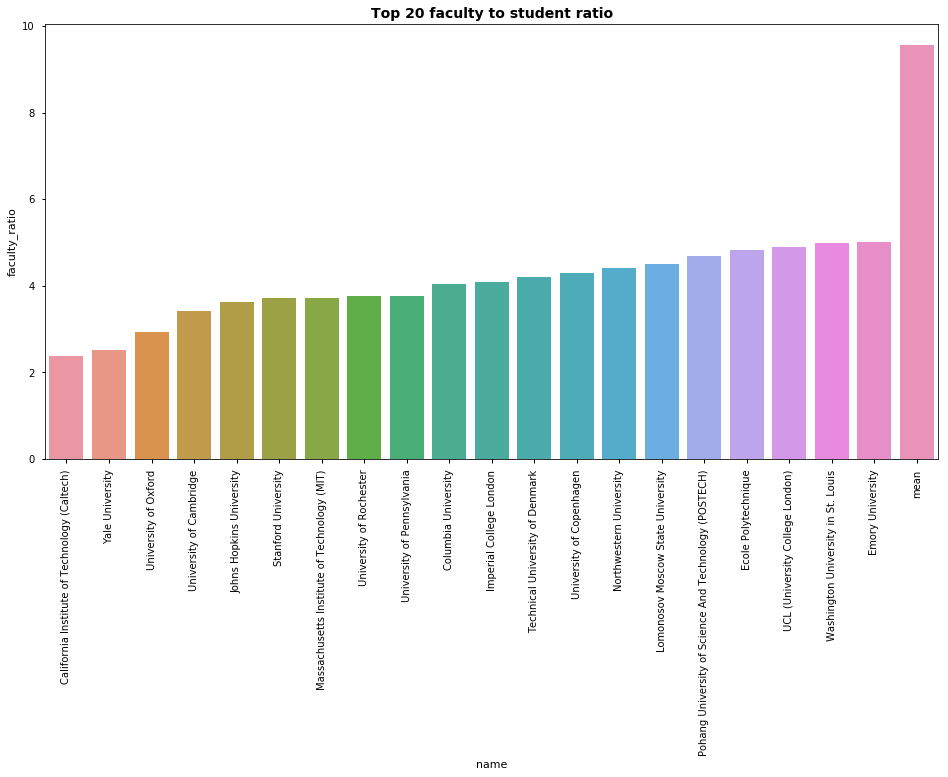

In [12]:
#Ploting results
#We added the mean value to have an order of magnitude
top_10_ratio_fac_mean = top_universities_df_ratio_fac_students[:20][['faculty_ratio','name']]
top_10_ratio_fac_mean.loc[-1] = [top_universities_df_ratio_fac_students['faculty_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(top_10_ratio_fac_mean.name, top_10_ratio_fac_mean['faculty_ratio'],ax=axes)
p.set_xticklabels(top_10_ratio_fac_mean.name,rotation=90)
p.set_title('Top 20 faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best universities in term of ratio of international students

In [13]:
#top_universities_df['international_students_ratio'] = top_universities_df['students_total']/top_universities_df['students_international']
top_universities_df_ratio_intern_students = top_universities_df.sort_values(by='international_ratio')[['international_ratio','name','rank','students_total','students_international','country','region']]
top_universities_df_ratio_intern_students.head()

,international_ratio,name,rank,students_total,students_international,country,region
34,1.446354,London School of Economics and Political Scien...,35,9760.0,6748.0,United Kingdom,Europe
11,1.754240,Ecole Polytechnique Fédérale de Lausanne (EPFL),12,10343.0,5896.0,Switzerland,Europe
7,1.839698,Imperial College London,8,16090.0,8746.0,United Kingdom,Europe
198,1.989920,Maastricht University,200,16385.0,8234.0,Netherlands,Europe
47,2.091778,Carnegie Mellon University,47,13356.0,6385.0,United States,North America


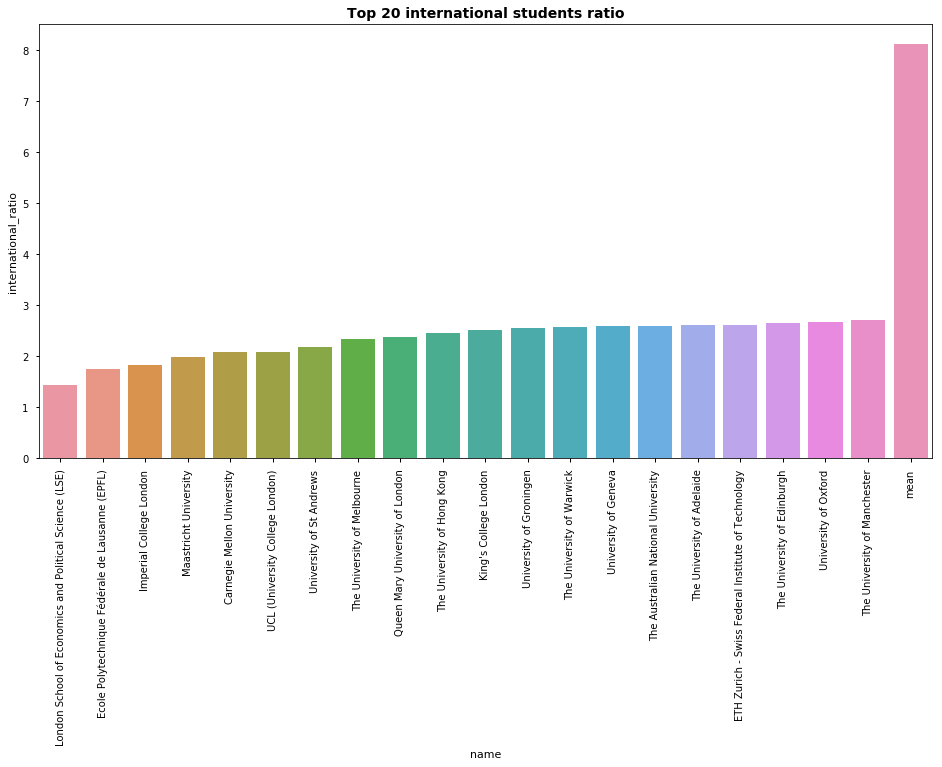

In [14]:
#Ploting results
#We added the mean value to have an order of magnitude
top_10_ratio_intern_mean = top_universities_df_ratio_intern_students[:20][['international_ratio','name']]
top_10_ratio_intern_mean.loc[-1] = [top_universities_df_ratio_intern_students['international_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(top_10_ratio_intern_mean.name, top_10_ratio_intern_mean['international_ratio'],ax=axes)
p.set_xticklabels(top_10_ratio_intern_mean.name,rotation=90)
p.set_title('Top 20 international students ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio between faculty members and students

In [15]:
top_country_ratio_fac_students = top_universities_df_ratio_fac_students.groupby('country').mean()['faculty_ratio'].sort_values()
top_country_ratio_fac_students

country
Russia             4.506335
Saudi Arabia       5.687382
Singapore          6.171431
Malaysia           6.498004
Japan              6.566145
Denmark            6.603256
South Korea        6.865503
Israel             7.350378
Argentina          7.447841
France             7.767984
Hong Kong          7.864368
Switzerland        7.983141
United Kingdom     8.281410
Norway             8.369801
Mexico             8.379077
United States      8.947140
China              9.043733
Finland            9.069738
Sweden             9.842832
Netherlands        9.963961
Canada            10.969435
South Africa      11.305828
Germany           11.788391
Chile             11.948230
Spain             12.072164
India             12.134018
Ireland           12.171548
Taiwan            12.543594
Brazil            12.636989
Australia         13.625141
Belgium           14.368971
Italy             14.551161
New Zealand       14.559223
Austria           19.116949
Name: faculty_ratio, dtype: float64

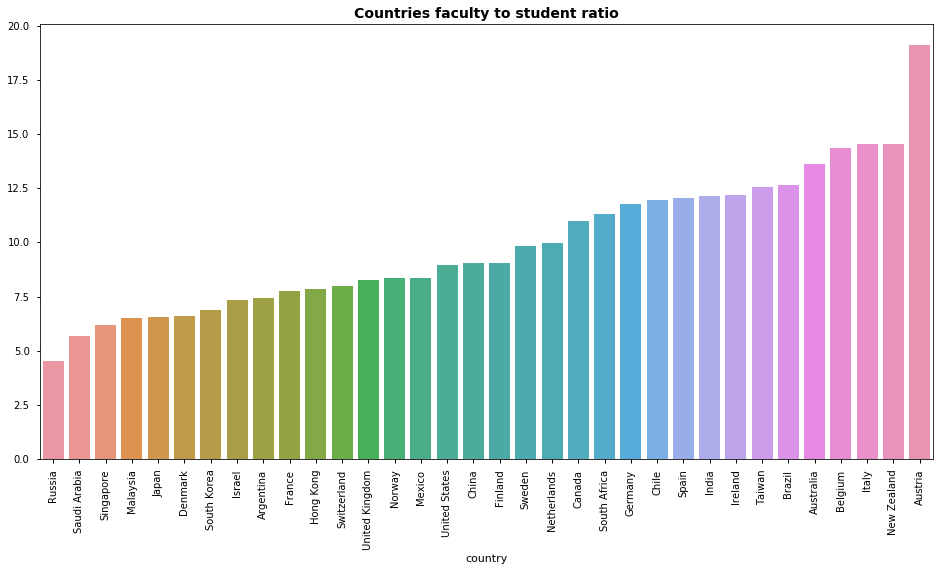

In [16]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(top_country_ratio_fac_students.index, top_country_ratio_fac_students.values,ax=axes)
p.set_xticklabels(top_country_ratio_fac_students.index,rotation=90)
p.set_title('Countries faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio of international students

In [17]:
top_country_ratio_intern_students = top_universities_df_ratio_intern_students.groupby('country').mean()['international_ratio'].sort_values()
top_country_ratio_intern_students

country
Australia          2.959934
United Kingdom     3.042695
Austria            3.269571
Hong Kong          3.312804
Singapore          3.609936
Switzerland        3.793660
New Zealand        4.123447
Canada             4.185048
Ireland            4.293649
Argentina          4.511454
Malaysia           5.150173
Netherlands        5.216193
France             5.363256
South Africa       5.892632
Russia             5.930365
United States      6.089623
Saudi Arabia       6.107179
Germany            6.181749
Sweden             6.559887
Denmark            6.641274
Belgium            6.642358
Spain              8.240049
Italy              9.631728
Norway            10.270204
Taiwan            10.957959
Japan             11.341621
South Korea       11.963950
China             11.967829
Finland           12.400913
Israel            15.987427
Chile             27.248234
Brazil            29.504103
Mexico            37.396231
India             93.725432
Name: international_ratio, dtype: float6

Because of the high values of some countries (India for example), we can not see a clear evolution between the "best" countries, so we decided to plot a second graph without the biggest ratio(>20)

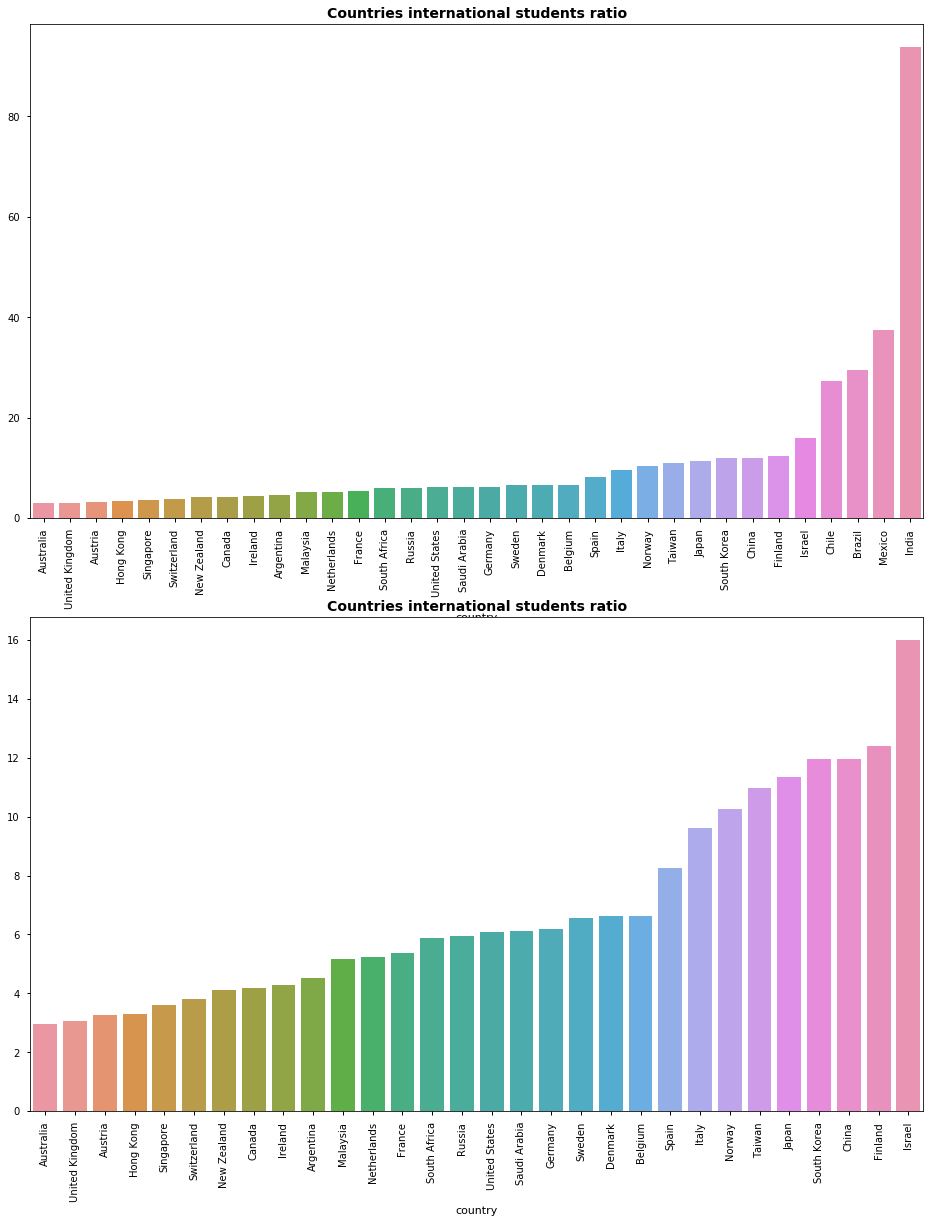

In [18]:
#Ploting results

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(2, 1, figsize=(16,20))
p=seaborn.barplot(top_country_ratio_intern_students.index, top_country_ratio_intern_students.values,ax=axes[0])
p.set_xticklabels(top_country_ratio_intern_students.index,rotation=90)
p.set_title('Countries international students ratio', fontsize=14, fontweight='bold')
best_country_intern = top_country_ratio_intern_students[top_country_ratio_intern_students.le(20)]
p=seaborn.barplot(best_country_intern.index, best_country_intern.values,ax=axes[1])
p.set_xticklabels(best_country_intern.index,rotation=90)
p.set_title('Countries international students ratio', fontsize=14, fontweight='bold')

### Best regions in term of ratio between faculty members and students

In [19]:
top_region_ratio_fac_students = top_universities_df_ratio_fac_students.groupby('region').mean()['faculty_ratio'].sort_values()
top_region_ratio_fac_students

region
Asia              7.977623
North America     9.214235
Europe            9.874120
Latin America    10.238034
Africa           11.305828
Oceania          13.794974
Name: faculty_ratio, dtype: float64

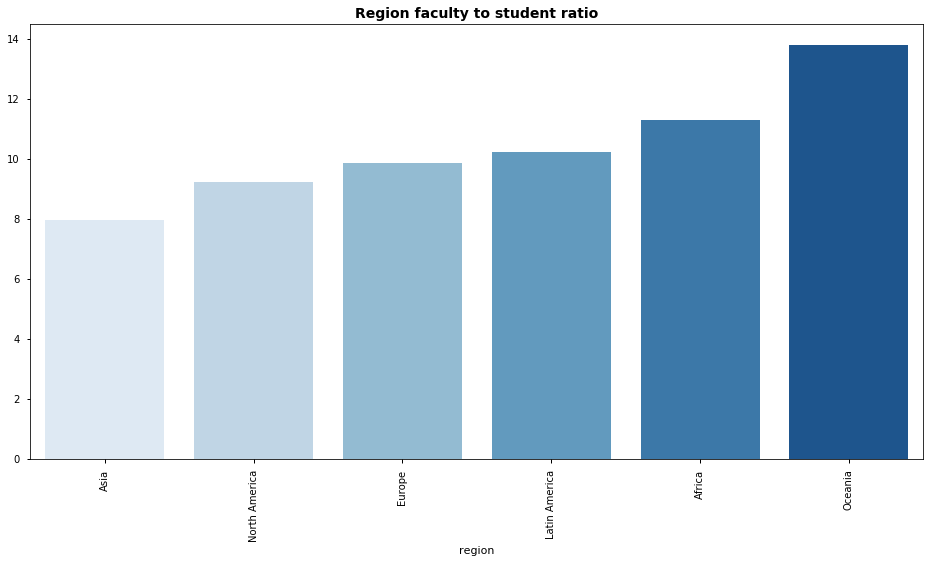

In [20]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(top_region_ratio_fac_students.index, top_region_ratio_fac_students.values,ax=axes)
p.set_xticklabels(top_region_ratio_fac_students.index,rotation=90)
p.set_title('Region faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best regions in term of ratio of international students

In [21]:
top_region_ratio_intern_students = top_universities_df_ratio_intern_students.groupby('region').mean()['international_ratio'].sort_values()
top_region_ratio_intern_students

region
Oceania           3.171482
Europe            5.254689
North America     5.838076
Africa            5.892632
Asia             16.413630
Latin America    27.593392
Name: international_ratio, dtype: float64

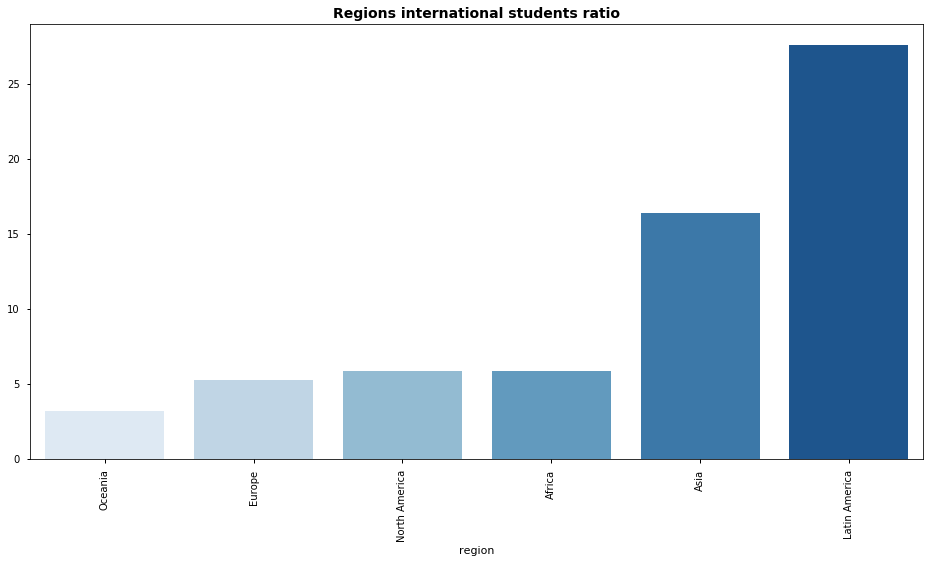

In [22]:
#Ploting results

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(top_region_ratio_intern_students.index, top_region_ratio_intern_students.values,ax=axes)
p.set_xticklabels(top_region_ratio_intern_students.index,rotation=90)
p.set_title('Regions international students ratio', fontsize=14, fontweight='bold')

### Additionnal plots

To have a better overview of the ranking we decided to plot a few representative data

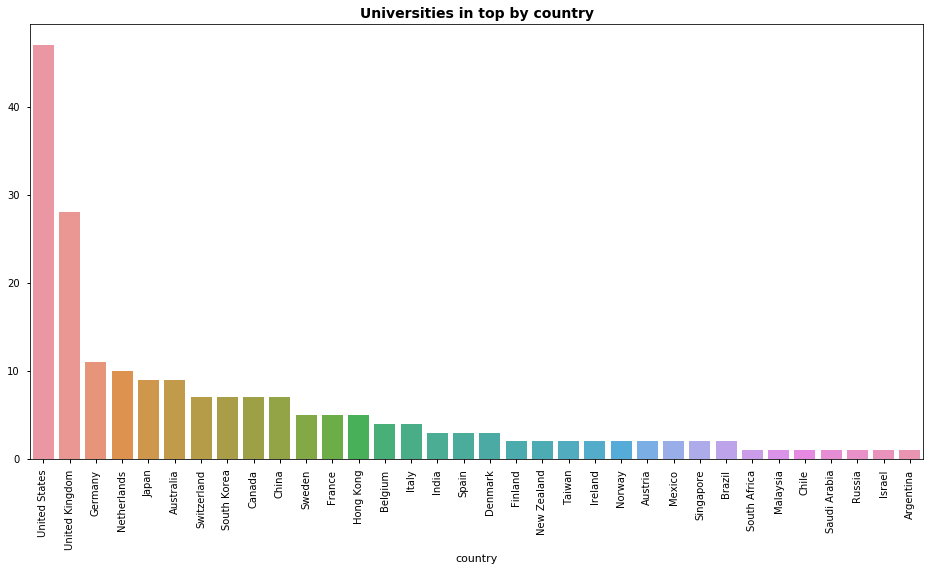

In [23]:
count_country = top_universities_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top by country', fontsize=14, fontweight='bold')

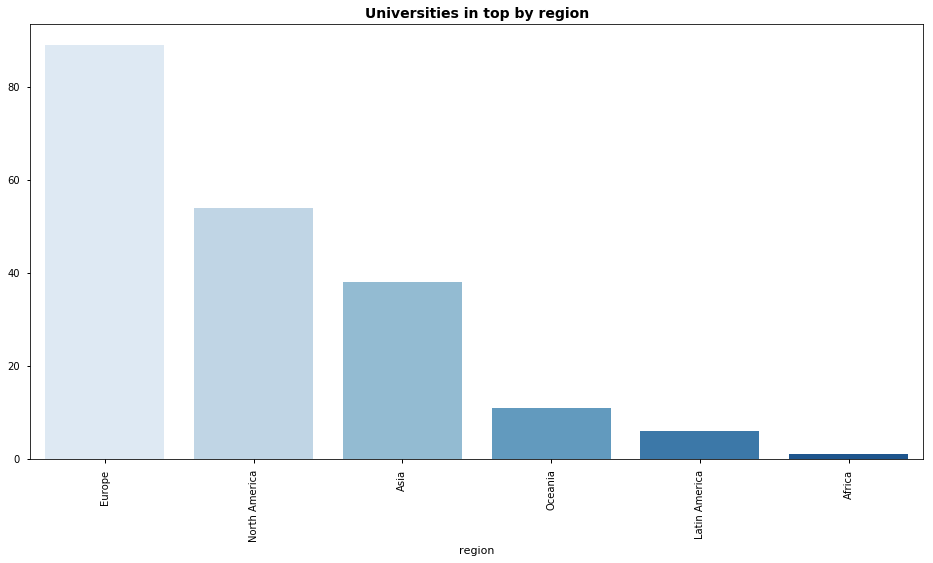

In [24]:
count_region = top_universities_df.groupby('region').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_region.index, count_region.values,ax=axes)
p.set_xticklabels(count_region.index,rotation=90)
p.set_title('Universities in top by region', fontsize=14, fontweight='bold')

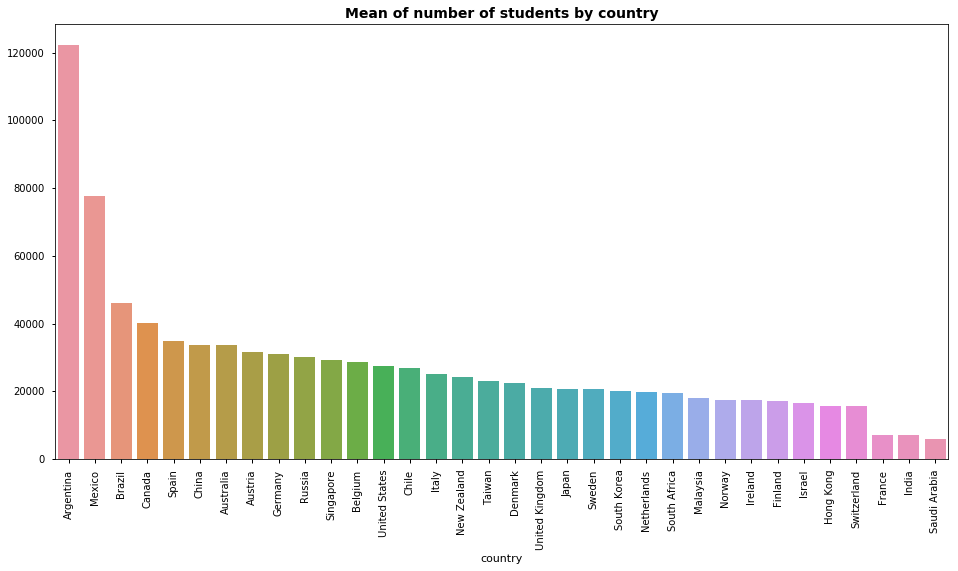

In [25]:
mean_country = top_universities_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country', fontsize=14, fontweight='bold')

We have to be careful with the previous plot, becasue we only take into account universities in the top 200, so all countries does not have the same number of universities. For example, only one university is ranked for Argentina, therefore it is not comparable with other countries such as USA.

## Times ranking

In [26]:
times_ranking_response = cached_get_request("https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json")
times_raw_ranking_data = times_ranking_response.json()['data']

def read_times_entry(raw_entry):
    from math import floor
    
    name = raw_entry["name"]
    rank = read_rank(raw_entry["rank"])
    # TODO: Assert this is always a country
    country = raw_entry["location"]
    # No region found
    region = None
    students_total = read_us_formatted_integer(raw_entry["stats_number_students"])
    
    international_students_ratio = read_percentage(raw_entry["stats_pc_intl_students"])
    students_international = floor(students_total * international_students_ratio)
    
    faculty_to_students_ratio = read_percentage(raw_entry["stats_student_staff_ratio"])
    faculty_total = floor(students_total * faculty_to_students_ratio)
    faculty_international = None
    faculty_ratio = faculty_to_students_ratio*100
    intern_ratio = international_students_ratio*100
    overall_score = float(raw_entry["scores_overall"]) if "scores_overall" in raw_entry else None
    citations_score = float(raw_entry["scores_citations"]) if "scores_citations" in raw_entry else None
    international_score = float(raw_entry["scores_international_outlook"]) if "scores_international_outlook" in raw_entry else None
    
    return make_entry(name, rank, country, region, faculty_total, faculty_international, students_total, students_international,faculty_ratio,intern_ratio,overall_score,citations_score,international_score)
    
#   uniProp['internStudentRatio']=t['stats_pc_intl_students']
#   uniProp['internStudent']=math.floor(float(t['stats_pc_intl_students'].replace("%",""))/100*int(t['stats_number_students'].replace(",","")))#Number looks like this 20,409
#   uniProp['totalFacultyRatio']=t['stats_student_staff_ratio']#TODO define which one we want to use
#   uniProp['totalFaculty']=math.floor(int(t['stats_number_students'].replace(",",""))/float(t['stats_student_staff_ratio']))
#   topBAsObjects.append(uniProp)
    
    result["intern_student"] = None
    
    # TODO define which one we want to use
    result["total_faculty_ratio"] = read_percentage(raw_entry["stats_student_staff_ratio"])
    
    result["total_faculty"] = None
    
    return result

def get_times_data(raw_ranking_data, max_rank):
    """
    Return the list of parsed enries (with details) of the top universities ranking.
    It may perform network requests.
    """
    for raw_entry in raw_ranking_data:
        entry = {}
        
        rank = read_rank(raw_entry["rank"])
        if (rank > max_rank):
            # Assume sorted raw ranks to break (instead of `continue`-ing)
            break

        yield read_times_entry(raw_entry)


def get_times_df(raw_ranking_data, max_rank):
    return pd.DataFrame([*get_times_data(raw_ranking_data, max_rank)])


times_df = get_times_df(times_raw_ranking_data, MAX_RANK)
times_df=times_df[['rank', 'name', 'country', 'region', 'students_total','faculty_total','students_international','faculty_international','faculty_ratio','international_ratio','overall_score','citations_score','international_score']]
times_df.head()

,rank,name,country,region,students_total,faculty_total,students_international,faculty_international,faculty_ratio,international_ratio,overall_score,citations_score,international_score
0,1,University of Oxford,United Kingdom,None,20409,2285,7755,None,11.2,38.0,94.3,99.1,95.0
1,2,University of Cambridge,United Kingdom,None,18389,2004,6436,None,10.9,35.0,93.2,97.5,93.0
2,3,California Institute of Technology,United States,None,2209,143,596,None,6.5,27.0,93.0,99.5,59.7
3,3,Stanford University,United States,None,15845,1188,3485,None,7.5,22.0,93.0,99.9,77.6
4,5,Massachusetts Institute of Technology,United States,None,11177,972,3800,None,8.7,34.0,92.5,100.0,87.6


## Analyse of the dataFrame

### Best universities in term of ratio between faculty members and students

In [27]:
times_df[:10]
#top_universities_df['faculty_student_ratio'] = top_universities_df['students_total']/top_universities_df['faculty_total']
times_universities_df_ratio_fac_students = times_df.sort_values(by='faculty_ratio')[['faculty_ratio','name','rank','students_total','faculty_total','country','region']]
times_universities_df_ratio_fac_students.head()


,faculty_ratio,name,rank,students_total,faculty_total,country,region
105,3.3,Vanderbilt University,105,12011,396,United States,None
109,4.1,University of Copenhagen,109,30395,1246,Denmark,None
12,4.3,Johns Hopkins University,13,15498,666,United States,None
11,4.3,Yale University,12,12155,522,United States,None
153,4.3,University of Rochester,153,9636,414,United States,None


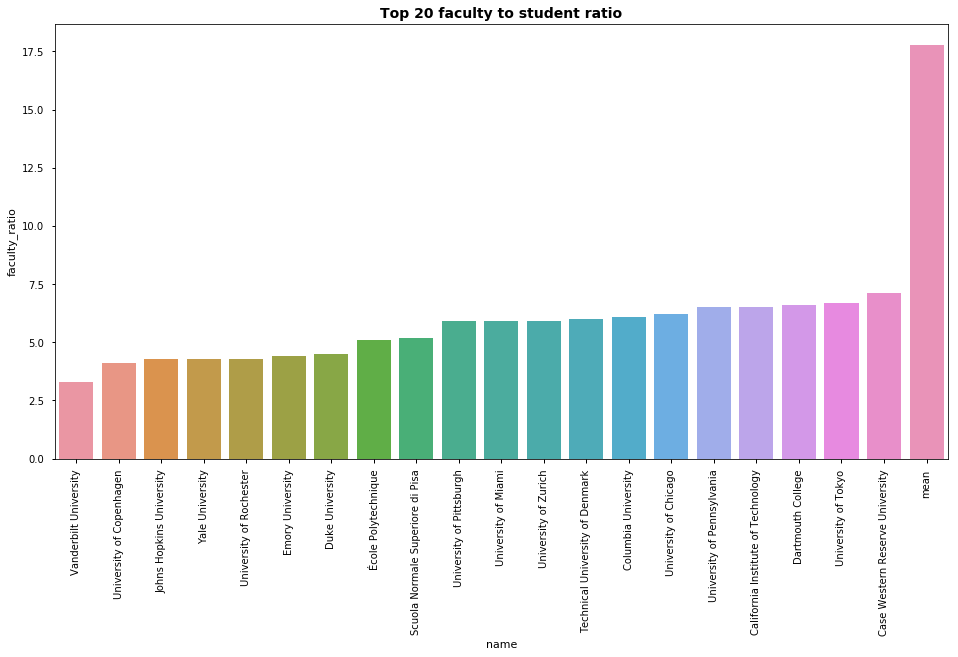

In [28]:
#Ploting results
#We added the mean value to have an order of magnitude
times_10_ratio_fac_mean = times_universities_df_ratio_fac_students[:20][['faculty_ratio','name']]
times_10_ratio_fac_mean.loc[-1] = [times_universities_df_ratio_fac_students['faculty_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_10_ratio_fac_mean.name, times_10_ratio_fac_mean['faculty_ratio'],ax=axes)
p.set_xticklabels(times_10_ratio_fac_mean.name,rotation=90)
p.set_title('Top 20 faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best universities in term of ratio of international students

In [29]:
#top_universities_df['international_students_ratio'] = top_universities_df['students_total']/top_universities_df['students_international']
times_universities_df_ratio_intern_students = times_df.sort_values(by='international_ratio')[['international_ratio','name','rank','students_total','students_international','country','region']]
times_universities_df_ratio_intern_students.head()

,international_ratio,name,rank,students_total,students_international,country,region
131,3.0,University of Science and Technology of China,132,16032,480,China,None
161,4.0,"University of California, Santa Cruz",162,17866,714,United States,None
136,4.0,Pohang University of Science and Technology,137,3046,121,South Korea,None
188,6.0,Shanghai Jiao Tong University,188,37288,2237,China,None
177,6.0,Zhejiang University,177,50051,3003,China,None


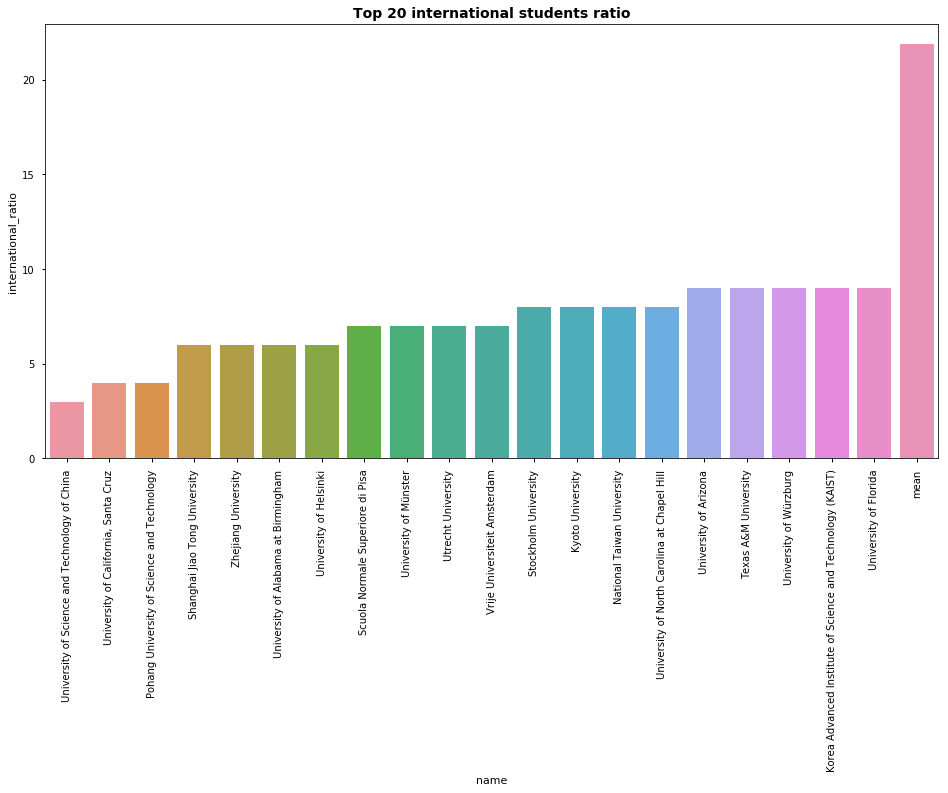

In [30]:
#Ploting results
#We added the mean value to have an order of magnitude
times_10_ratio_intern_mean = times_universities_df_ratio_intern_students[:20][['international_ratio','name']]
times_10_ratio_intern_mean.loc[-1] = [times_universities_df_ratio_intern_students['international_ratio'].mean(), 'mean'] 

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_10_ratio_intern_mean.name, times_10_ratio_intern_mean['international_ratio'],ax=axes)
p.set_xticklabels(times_10_ratio_intern_mean.name,rotation=90)
p.set_title('Top 20 international students ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio between faculty members and students

In [31]:
times_country_ratio_fac_students = times_universities_df_ratio_fac_students.groupby('country').mean()['faculty_ratio'].sort_values()
times_country_ratio_fac_students

country
Russian Federation     7.300000
Japan                  7.700000
Denmark                8.133333
Italy                  8.450000
Taiwan                11.500000
South Africa          11.700000
United States         11.904839
China                 11.942857
South Korea           13.300000
France                13.450000
Switzerland           13.514286
United Kingdom        13.661290
Luxembourg            14.600000
Sweden                15.200000
Singapore             16.650000
Spain                 16.850000
Finland               18.200000
Netherlands           18.330769
Norway                18.600000
New Zealand           18.800000
Hong Kong             19.300000
Canada                19.716667
Austria               20.800000
Ireland               22.800000
Australia             27.462500
Belgium               38.550000
Germany               44.025000
Name: faculty_ratio, dtype: float64

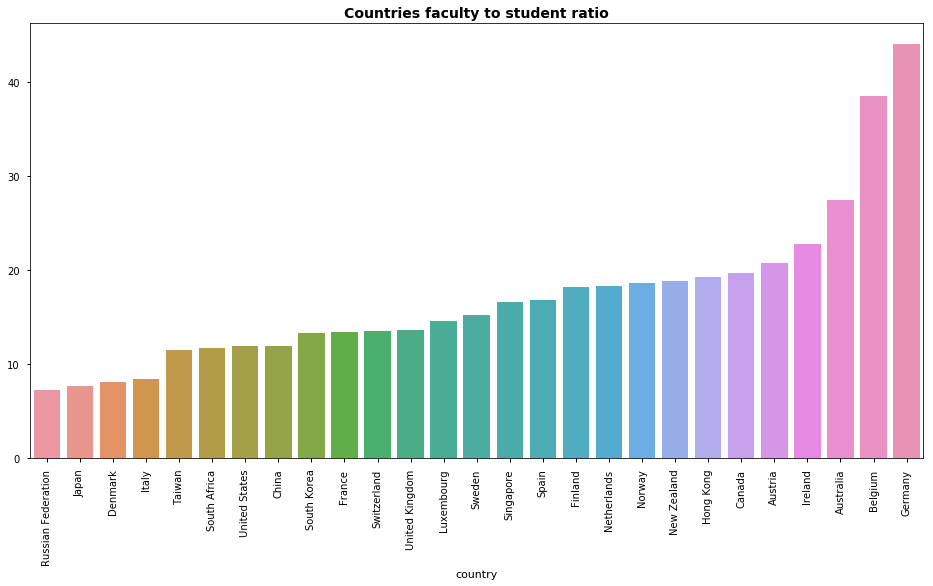

In [32]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_country_ratio_fac_students.index, times_country_ratio_fac_students.values,ax=axes)
p.set_xticklabels(times_country_ratio_fac_students.index,rotation=90)
p.set_title('Countries faculty to student ratio', fontsize=14, fontweight='bold')
p

### Best countries in term of ratio of international students

In [33]:
times_country_ratio_intern_students = times_universities_df_ratio_intern_students.groupby('country').mean()['international_ratio'].sort_values()
times_country_ratio_intern_students

country
Taiwan                 8.000000
China                  8.571429
Japan                  9.000000
South Korea            9.000000
Italy                 10.500000
Finland               13.000000
Spain                 14.000000
Sweden                14.000000
Germany               15.200000
Denmark               16.666667
South Africa          18.000000
United States         18.177419
Norway                19.000000
Netherlands           19.230769
Belgium               19.750000
France                20.833333
Russian Federation    22.000000
Canada                22.500000
Austria               26.000000
Ireland               27.000000
New Zealand           29.000000
Singapore             30.500000
Australia             30.750000
Switzerland           31.428571
Hong Kong             32.800000
United Kingdom        36.548387
Luxembourg            57.000000
Name: international_ratio, dtype: float64

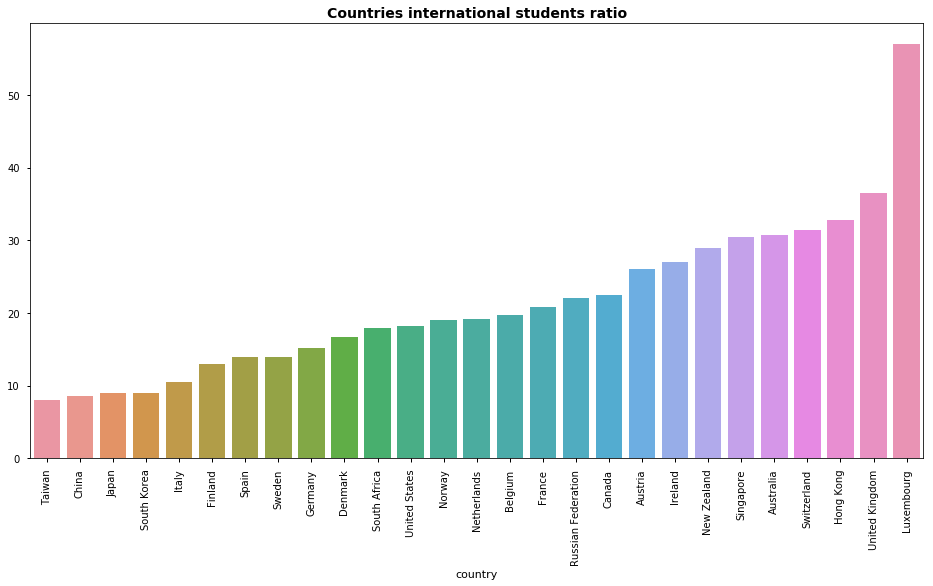

In [34]:
#Ploting results
#top_country_ratio_fac_students.loc['mean'] = top_country_ratio_fac_students.mean()

seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(times_country_ratio_intern_students.index, times_country_ratio_intern_students.values,ax=axes)
p.set_xticklabels(times_country_ratio_intern_students.index,rotation=90)
p.set_title('Countries international students ratio', fontsize=14, fontweight='bold')
p

# TODO : with regions ? 

### Additionnal plots

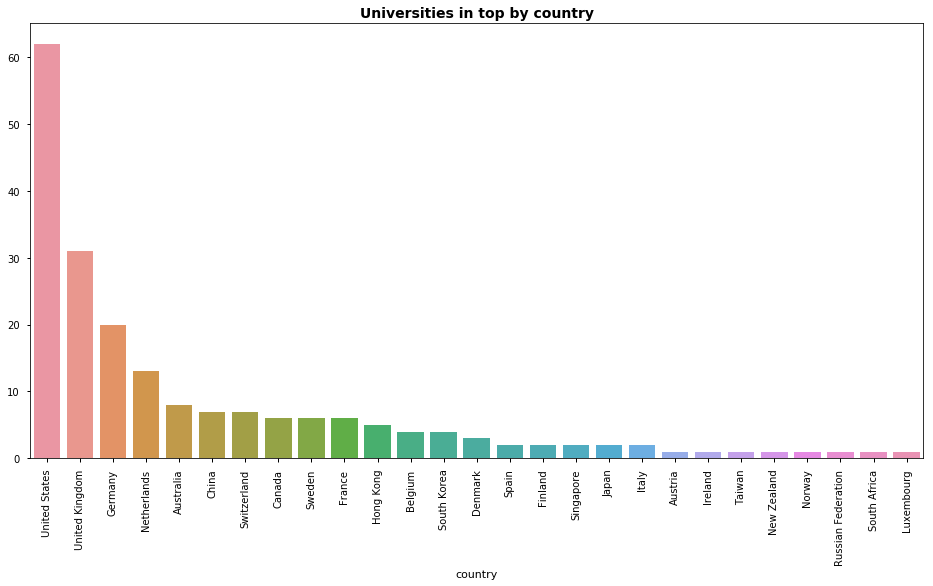

In [35]:
count_country = times_df.groupby('country').count()['rank'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(count_country.index, count_country.values,ax=axes)
p.set_xticklabels(count_country.index,rotation=90)
p.set_title('Universities in top by country', fontsize=14, fontweight='bold')

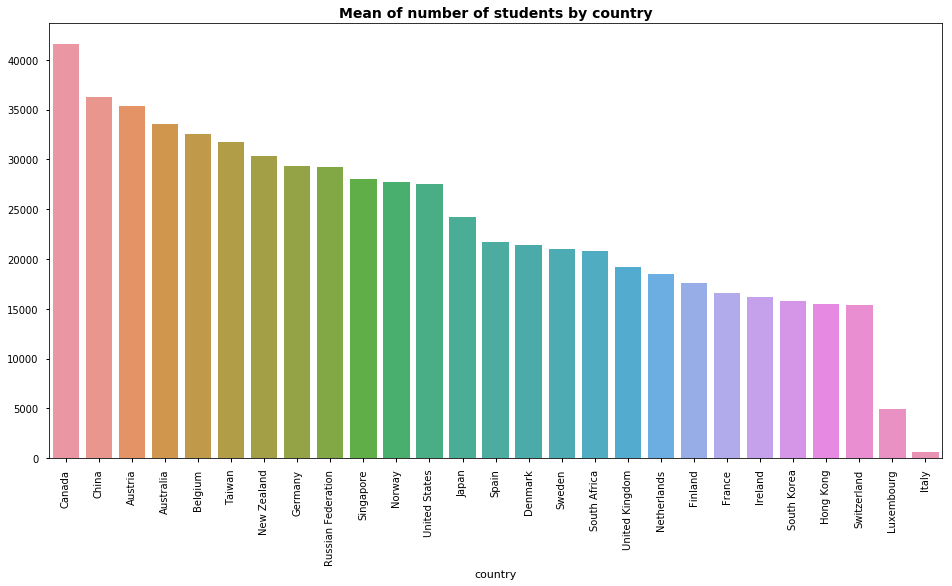

In [36]:
mean_country = times_df.groupby('country').mean()['students_total'].sort_values(ascending=False)
seaborn.set_palette('Blues')
seaborn.set_context("notebook")
figure, axes = plt.subplots(1, 1, figsize=(16,8))
p=seaborn.barplot(mean_country.index, mean_country.values,ax=axes)
p.set_xticklabels(mean_country.index,rotation=90)
p.set_title('Mean of number of students by country', fontsize=14, fontweight='bold')

## Question 3

First, we do a classic merge by doing a perfect match with the name of the universities, to reduce the size of the two mismatches data frames.

Then, we performed some text pre-processing on the name of those universities, by removing accents, punctuation, translating foreign words and synonyms to a common English word, and by generating a set of tokens containing words and bigrams.

Then, for each pairs of mismatching universities, we measured the distance between the two sets using this formula : $$\frac{\mathbf{card}(A \cap B)}{\mathbf{card}(A \cup B)}$$

Afterwards, we selected the best match for A in B, and vice versa, to obtain the best possible pairs, without duplicates.

Next, we plotted the distribution of similarity values, to decide on a range of thresholds, before doing some trials and errors to find the best threshold which removes incorrect pairs but keeps a maximum of good ones.

In [236]:
import string
from math import sqrt

def text_synonyms(text):
    synonyms = {
        'universiti':'university', 
        'universite':'university', 
        'universitat':'university', 
        'universitaet':'university', 
        'universidad':'university', 
        'universidade':'university', 
        'universiteit':'university',
        'king\'s':'kings'
    }
    return [word if not(word in synonyms) else synonyms[word] for word in text]

def text_bigrams(text):
    """
    Return the bigrams of the list of tokens
    """
    bigrams  = []
    for index, word in enumerate(text):
        if index + 1 < len(text):
            bigrams += [word + " " + text[index + 1]]
    return bigrams

def text_remove_accents(text):
    try:
        import unidecode
        return unidecode.unidecode(text)
    except ImportError:
        return text.translate(str.maketrans('àáâãäåçèéêëìíîïðñòóôõöøùúûüýÿšž', 'aaaaaaceeeeiiiidnoooooouuuuyysz'))

def text_preprocessing(df, columns="name", suffix="_preprocessed", stopwords=set(["le", "la", "the", "of", "de", "and", "at", "et"])):
    """
    For all selected textual columns of dataframe, 
    append a new preprocessed column which consist of a set of tokens and bigrams
    extracted from text, without any punctuations/accents/uppercases/stopwords.
    """
    data = df[[columns]]
    data = data.applymap(lambda text: text_remove_accents(text.lower().translate(str.maketrans('-–', '  ')).translate(str.maketrans('', '', string.punctuation))))
    data = data.applymap(lambda text: [token for token in text.split() if token not in stopwords])
    data = data.applymap(lambda text: text_synonyms(text))
    data = data.applymap(lambda text: set(text + text_bigrams(text)))
    data = data.add_suffix(suffix)
    return df.join(data)

def dataframe_crossjoin(A, B, suffixes=('_A', '_B')):
    """
    Return the cartesian product between the two DataFrames
    """
    A['_tmpkey'] = 1
    B['_tmpkey'] = 1

    AB = pd.merge(A, B, on='_tmpkey', suffixes=suffixes).drop('_tmpkey', axis=1)
    AB.index = pd.MultiIndex.from_product((A.index, B.index))

    A.drop('_tmpkey', axis=1, inplace=True)
    B.drop('_tmpkey', axis=1, inplace=True)

    return AB

def set_distance(A, B):
    """
    Return the distance between two sets, card(A & B) / card(A | B)
    """
    inter = A.intersection(B)
    union = A.union(B)
    return (len(inter) / len(union))

def merge_data(A , B, left_on="name", right_on="name", suffixes=('_A', '_B'), similarity=0.50):
    """
    Merge the data according to the similarity between the two sets of words
    """
    #Exact macth
    exact_matches = A.merge(B, left_on=left_on, right_on=right_on, how="inner", suffixes=suffixes)
    
    #Select doesn't match
    A_no_matches  = A[~A[left_on ].isin(exact_matches[left_on ])]
    B_no_matches  = B[~B[right_on].isin(exact_matches[right_on])]
    
    A = text_preprocessing(A_no_matches, left_on )
    B = text_preprocessing(B_no_matches, right_on)
    
    #Select amongst all possibles pairs, the best one, with a similarity at least higher than the threshold
    cross = dataframe_crossjoin(A, B, suffixes)
    
    selected_cross = cross[[left_on  + "_preprocessed" + suffixes[0], right_on + "_preprocessed" + suffixes[1]]]
    selected_cross = pd.DataFrame(selected_cross.apply(lambda x: set_distance(x[0], x[1]), axis=1))
    selected_cross = selected_cross.loc[selected_cross.groupby(level=0).idxmax()[0]]
    selected_cross = selected_cross.loc[selected_cross.groupby(level=1).idxmax()[0]]
    selected_cross = (selected_cross >= similarity)[0]
    selected_cross = selected_cross[selected_cross].index.tolist()
    
    #We select the first name as the reference
    left  = [left_on + suffixes[0]]
    right = exact_matches.columns.tolist()
    right.remove(right_on)
    fuzzy_matches = cross.loc[selected_cross][left + right].reindex()
    fuzzy_matches.columns = exact_matches.columns
    
    A_no_matches = A_no_matches[~A_no_matches.index.isin([x[0] for x in fuzzy_matches.index.values])]
    B_no_matches = B_no_matches[~B_no_matches.index.isin([x[1] for x in fuzzy_matches.index.values])]
    
    matches = exact_matches.append(fuzzy_matches)
    matches.index = [i for i in range(0, matches.shape[0])]
    
    #return cross.loc[selected_cross], A_no_matches, B_no_matches
    return matches, A_no_matches, B_no_matches
    
m, a, b = merge_data(times_df[["name", "rank"]], top_universities_df[["name", "rank"]], suffixes=('_times','_top_universities'))
m

,name,rank_times,rank_top_universities
0,University of Oxford,1,6
1,University of Cambridge,2,5
2,Stanford University,3,2
3,Harvard University,6,3
4,Princeton University,7,13
5,Imperial College London,8,8
6,University of Chicago,9,9
7,University of Pennsylvania,10,19
8,Yale University,12,16
9,Johns Hopkins University,13,17


# Part 4

We calculate all correlations between all pairs of variables before printing the distribution of values to select a good threshold in order to extract good correlations.

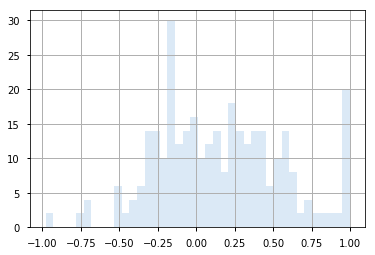

In [377]:
m, a, b = merge_data(times_df, top_universities_df, suffixes=('_times','_top_universities'))
corr = m.corr().stack()
corr.hist(bins=40)

We remove too low and too high correlations (like the total number of students in both ranking) which are not useful, and we remove duplicates.

In [379]:
selec = corr[(abs(corr) > 0.6) & (abs(corr) < 1)] #Remove below moderate and perfect relationships.
selec = selec[~pd.DataFrame(np.sort(np.array(selec.index.tolist()), 1)).duplicated().values].to_frame()
selec

0
students_total_times            faculty_total_times                      0.709285
                                students_total_top_universities          0.979262
                                faculty_total_top_universities           0.606552
faculty_total_times             faculty_ratio_times                      0.865148
                                students_total_top_universities          0.713244
students_international_times    students_international_top_universities  0.926789
international_ratio_times       international_score_times                0.785412
                                international_ratio_top_universities    -0.727679
                                international_score_top_universities     0.642791
overall_score_times             rank_top_universities                   -0.748555
                                overall_score_top_universities           0.817694
international_score_times       international_ratio_top_universities    -0.730178
                                international_score_top_universities     0.685346
rank_top_universities           overall_score_top_universities          -0.978757
students_total_top_universities students_international_top_universities  0.622657
faculty_total_top_universities  faculty_international_top_universities   0.632006

Then, we can print the plots of some interesting correlations.

In [380]:
def plot(x, y):
    plt.scatter(m[x], m[y])
    print("correlation : " + str(corr[x,y]))

In [381]:
from ipywidgets import interact
interact(plot, x=corr.index.levels[0].tolist(), y=corr.index.levels[1].tolist())

A Jupyter Widget

<function __main__.plot>

We have a high correlation between the overall scores of the two rankings.

correlation : 0.817694253734


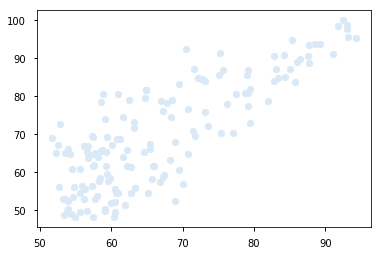

In [382]:
plot("overall_score_times", "overall_score_top_universities")

correlation : 0.785411865295


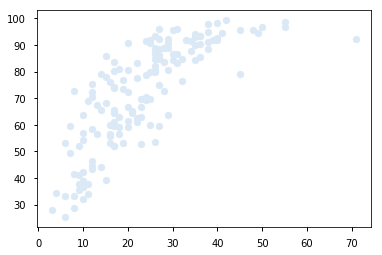

In [385]:
plot("international_ratio_times", "international_score_times")

# Part 5 


Our first idea was to use the mean of the 2 ranks to make a new feature. It is simple to do from previous rankings.


In [103]:
m, a, b = merge_data(times_df[["name", "rank","overall_score","citations_score","international_score"]], top_universities_df[["name", "rank","overall_score","citations_score","international_score"]], suffixes=('_times','_top_universities'))

In [104]:
merging_rank = m.copy()
linear_ratio_top = top_universities_df.copy()
linear_ratio_times = times_df.copy()
#Take the mean
merging_rank['mean_of_rank'] = (merging_rank['rank_times']+merging_rank['rank_top_universities'])/2
#Sort by our new column
merging_rank.sort_values(by="mean_of_rank",inplace=True)
#Reindex
merging_rank.reset_index(drop=True,inplace=True)
merging_rank[["name","mean_of_rank","rank_times","rank_top_universities"]]

,name,mean_of_rank,rank_times,rank_top_universities
0,Stanford University,2.5,3,2
1,Massachusetts Institute of Technology,3.0,5,1
2,California Institute of Technology,3.5,3,4
3,University of Oxford,3.5,1,6
4,University of Cambridge,3.5,2,5
5,Harvard University,4.5,6,3
6,Imperial College London,8.0,8,8
7,University of Chicago,9.0,9,9
8,Princeton University,10.0,7,13
9,ETH Zurich – Swiss Federal Institute of Techno...,10.0,10,10


We can see that the leader of this new ranking is neither the leader of the topuniversities nor the one from the times. 
This ranking leads us to a question, is the difference between the first and second is the same as the difference between the second and third? 
To answer this question we tried to use more precise criteria.

For example we have following scores : 
**Times** 
* overall score
* teaching
* research
* citations
* industry income
* international outlook

**top**
* academic reputation
* citations per faculty
* employer reputation
* faculty student
* international faculty
* international student

We can notice similar categories : 
The most important is overall score. 

To validate the first ranking we have to obtain a linear relation between the score and the rank

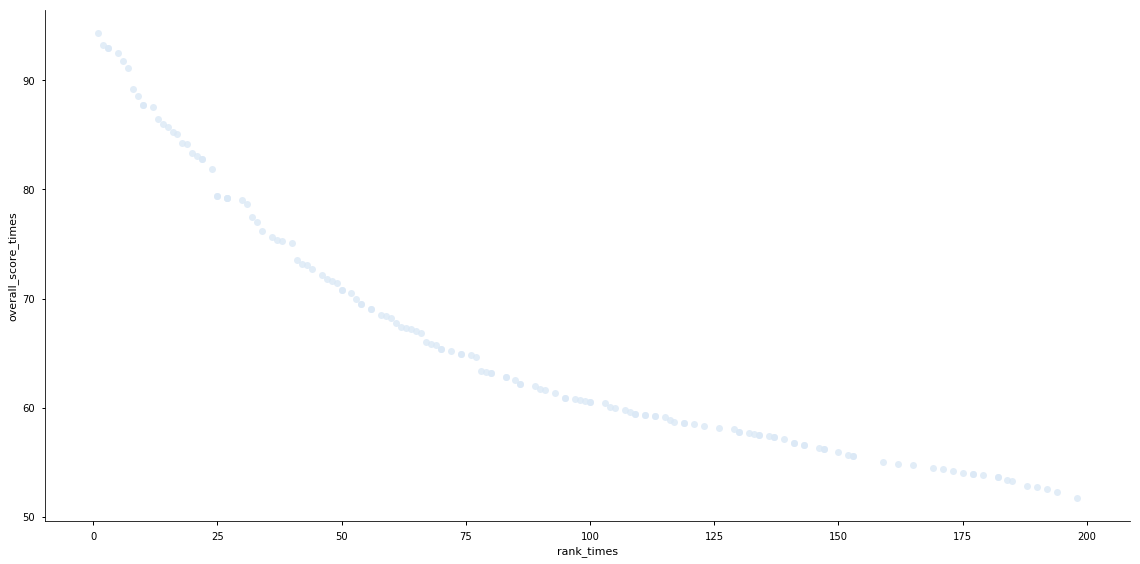

In [105]:
p=seaborn.lmplot("rank_times", "overall_score_times",data=m,fit_reg=False,size=8,aspect=2)

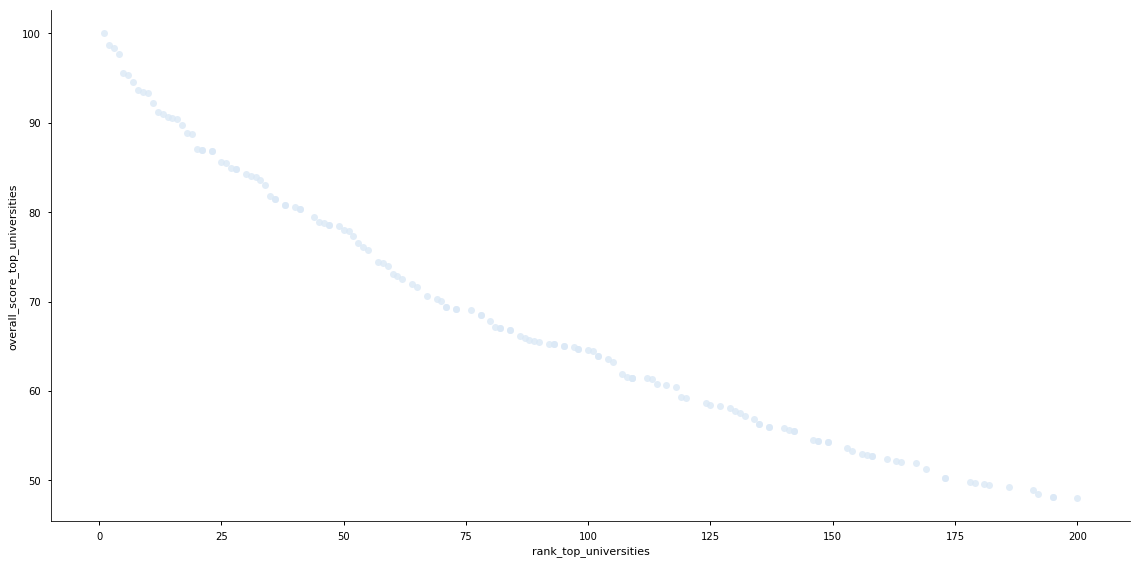

In [106]:
p=seaborn.lmplot("rank_top_universities", "overall_score_top_universities",data=m,fit_reg=False,size=8,aspect=2)

It is not too far from linear but not enough to be precise. To be sure we will plot the difference between each row and see if it is close to a constant.

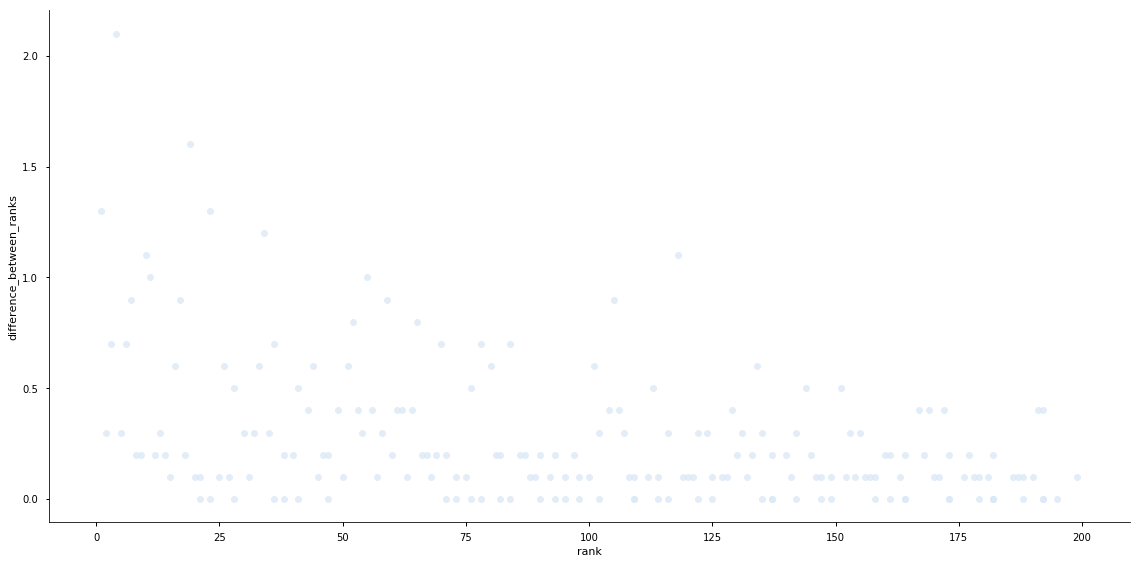

In [107]:
linear_ratio_top['difference_between_ranks'] = linear_ratio_top['overall_score'] - linear_ratio_top['overall_score'].shift(-1)
ratio_top_no_outliers=linear_ratio_top[linear_ratio_top.difference_between_ranks.le(3)]

p=seaborn.lmplot("rank", "difference_between_ranks",data=ratio_top_no_outliers[ratio_top_no_outliers.difference_between_ranks.ge(-3)],fit_reg=False,size=8,aspect=2)
#Note that there were 2 outliers, we remove them to have a better plot

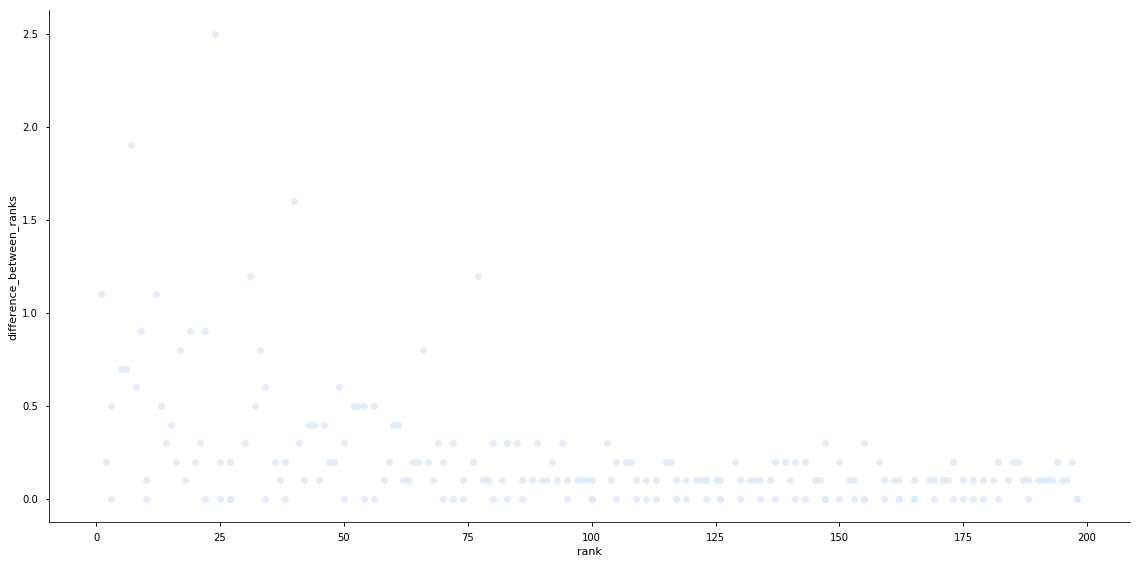

In [108]:
linear_ratio_times['difference_between_ranks'] =linear_ratio_times['overall_score'] - linear_ratio_times['overall_score'].shift(-1)
p=seaborn.lmplot("rank", "difference_between_ranks",data=linear_ratio_times,fit_reg=False,size=8,aspect=2)

We can really see that the difference fluctuates greatly, especially for top ranks.
So we will not use mean of ranks as feature to our new ranking, instead we can use the mean of overall_scores for both rankings. 
First let's normalize the data, both scores are rated out of 100 but we do not know at which score it begins.

In [109]:
print("Maximum score for times is : {} and minimum score in the top 200 is : {}".format(m["overall_score_times"].max(),m["overall_score_times"].min()))
print("Maximum score for top universities is : {} and minimum score in the top 200 is : {}".format(m["overall_score_top_universities"].max(),m["overall_score_top_universities"].min()))

Maximum score for times is : 94.3 and minimum score in the top 200 is : 51.7
Maximum score for top universities is : 100.0 and minimum score in the top 200 is : 48.0


We will rescale both ranking scores so that they fit this scale [0;100], then we will take the mean.

In [110]:
def normalize_column(df,column_name,new_column,min_scale,max_scale):
    min_= df[column_name].min()
    df[new_column]=df[column_name]-(min_-min_scale)
    max_ = df[new_column].max()
    df[new_column]/=(max_/max_scale)

In [111]:
merging_score = m.copy()
#First normalize
normalize_column(merging_score,'overall_score_times','norm_overall_score_times',0,100)
normalize_column(merging_score,'overall_score_top_universities','norm_overall_score_top',0,100)

#Then take the mean
merging_score['mean_of_score'] = (merging_score['norm_overall_score_times']+merging_score['norm_overall_score_top'])/2
# Sort and reindex
merging_score.sort_values(by="mean_of_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
merging_score[["name","mean_of_score","overall_score_times","norm_overall_score_times","overall_score_top_universities","norm_overall_score_top"]]

,name,mean_of_score,overall_score_times,norm_overall_score_times,overall_score_top_universities,norm_overall_score_top
0,Massachusetts Institute of Technology,97.887324,92.5,95.774648,100.0,100.000000
1,Stanford University,97.224178,93.0,96.948357,98.7,97.500000
2,California Institute of Technology,96.262640,93.0,96.948357,97.7,95.576923
3,Harvard University,95.527266,91.8,94.131455,98.4,96.923077
4,University of Oxford,95.480769,94.3,100.000000,95.3,90.961538
5,University of Cambridge,94.478151,93.2,97.417840,95.6,91.538462
6,Imperial College London,87.956392,89.2,88.028169,93.7,87.884615
7,Princeton University,87.590285,91.1,92.488263,91.0,82.692308
8,University of Chicago,87.059859,88.6,86.619718,93.5,87.500000
9,ETH Zurich – Swiss Federal Institute of Techno...,85.811213,87.7,84.507042,93.3,87.115385


Scores that are also presents : 
* citations 
    * times : 30% 
    * top : 20%
    * times : We examine research influence by capturing the number of times a university’s published work is cited by scholars globally.
    * Top : To calculate it, we the total number of citations received by all papers produced by an institution across a five-year period by the number of faculty members at that institution.
    * Both are normalized
* international outlook and mean of (international faculty and international student)
    * times : 7,5%
    * Top 2* 5% 
    * Times : calculated like this :
        * International-to-domestic-student ratio: 2.5%
        * International-to-domestic-staff ratio: 2.5%
        * International collaboration: 2.5%
Maybe we can use mean of overall score and take more into account citations and international outlook at it is present in both ranking 
We will use the following formula : New score = Mean(0.6\*overall_score+0.3\*citations_score+0.1\*international_score)
How did we end up with this formula ? 
We think that the overall score remains the most important factor, but to compare both scores we will just add weigth to common criteria.
We don't want to add too much importance to the criteria, so we keep overall score for 60% of the new score. Then we keep the ratio used by both times and top universities between citations and international_score.

Once again we will take normalized scores between [0;100]

Note that we already got citations scores when building the dataFrame. We got at the same time the international outlook score for times and built the international outlook score for top universities as the mean of international faculty and international student

In [112]:
print("Maximum score for citations in times is : {} and minimum score in the top 200 is : {}".format(m["citations_score_times"].max(),m["citations_score_times"].min()))
print("Maximum score for citations in top universities is : {} and minimum score in the top 200 is : {}".format(m["citations_score_top_universities"].max(),m["citations_score_top_universities"].min()))
print("Maximum score for international outlook in times is : {} and minimum score in the top 200 is : {}".format(m["international_score_times"].max(),m["international_score_times"].min()))
print("Maximum score for international outlook in top universities is : {} and minimum score in the top 200 is : {}".format(m["international_score_top_universities"].max(),m["international_score_top_universities"].min()))

Maximum score for citations in times is : 100.0 and minimum score in the top 200 is : 15.8
Maximum score for citations in top universities is : 100.0 and minimum score in the top 200 is : 23.4
Maximum score for international outlook in times is : 99.5 and minimum score in the top 200 is : 25.2
Maximum score for international outlook in top universities is : 100.0 and minimum score in the top 200 is : 19.95


In [113]:
#First normalize
normalize_column(merging_score,'citations_score_times','norm_citations_score_times',0,100)
normalize_column(merging_score,'citations_score_top_universities','norm_citations_score_top',0,100)
normalize_column(merging_score,'international_score_times','norm_international_score_times',0,100)
normalize_column(merging_score,'international_score_top_universities','norm_international_score_top',0,100)
#Then create new scores
merging_score['new_score_times'] = 0.6 * merging_score['norm_overall_score_times'] + 0.3*merging_score['norm_citations_score_times']+0.1*merging_score["norm_international_score_times"]
merging_score['new_score_top_universities'] = 0.6 * merging_score['norm_overall_score_top'] + 0.3*merging_score['norm_citations_score_top']+0.1*merging_score["norm_international_score_top"]
#Take the mean 
merging_score['mean_of_new_score'] = (merging_score['new_score_times']+merging_score['new_score_top_universities'])/2
#Sort and reindex
merging_score.sort_values(by="mean_of_new_score",inplace=True,ascending=False)
merging_score.reset_index(drop=True,inplace=True)
#Finally enjoy because it's the end
merging_score[["name","mean_of_new_score","new_score_times","new_score_top_universities","overall_score_times","overall_score_top_universities"]]

,name,mean_of_new_score,new_score_times,new_score_top_universities,overall_score_times,overall_score_top_universities
0,Massachusetts Institute of Technology,97.790206,95.863174,99.717238,92.5,100.0
1,Stanford University,95.860359,95.185875,96.534844,93.0,98.7
2,Harvard University,95.027075,93.707113,96.347036,91.8,98.4
3,California Institute of Technology,94.446769,92.634205,96.259333,93.0,97.7
4,University of Oxford,92.093742,99.073682,85.113802,94.3,95.3
5,University of Cambridge,91.401730,96.685136,86.118324,93.2,95.6
6,ETH Zurich – Swiss Federal Institute of Techno...,90.085030,88.484921,91.685139,87.7,93.3
7,Princeton University,89.153138,92.550978,85.755297,91.1,91.0
8,Imperial College London,85.861552,91.250820,80.472284,89.2,93.7
9,University of Chicago,85.847385,87.733828,83.960942,88.6,93.5


With our new ranking we can notice important changes. For example, ETH moved from 9th to 4th place. 
This may seem counterintuitive because ETH is less well ranked in each of the 2 rankings. Nevertheless, our new classification highlights the similarities of previous classifications, in order to use common measures instead of separate metrics.